# <h1 style="text-align:center;">Stock Price Forecast with LSTM & Prophet</h1>

**Author:** Vitor Hugo Peixoto

### What is a Stock price?
Companies that become public, which means those which the general public can invest onto, are divided in small fractions called shares. Those shares are available for purchase in the form of investment, and the price of each share varies depending on the revenue of said company, the amount of shares at the public disposal, the stability of the company's finances, industry trends and so on... The more shares are purchased the higher the price of each share becomes, following the supply and demand logic. The opposite is also true. The stock price could be affected though by poor management of the company, an economic recession, and many other factors.
In other words, a Stock price is the value of the public sentiment towards publicly traded companies.

In this notebook we aim at analyzing and creating an LSTM and a Prophet model to forecast the future stock price of Apple.

### What is LSTM?
LSTM stands for Long Short-Term Memory, and it is a type of recurrent neural network (RNN) architecture designed to overcome some of the limitations of traditional RNNs in handling long-range dependencies and learning from sequential data.

Seeing how stock prices are a type of sequential data and we aim to predict it long-term, LSTM could be a great model to use.

### What is Prophet?
Prophet is a forecasting tool developed by Facebook for time-series analysis and forecasting. It is designed to handle daily observations that display patterns on different time scales.

This tool is great at detecting drastic changes in the data and handling missing values, as well as accounting for holidays. 

It has found an increased usage in the financial sector in recent years.

Without much further ado we can begin our modelling. For a more throughly understanding of the data preprocessing steps refer to the notebook 'CAPSTONE PROJECT  - Stock Price Prediction with ARIMA model'

In [70]:
# import libraries
import numpy as np
import pandas as pd

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler

In [72]:
# read Apple data
aapl_df = pd.read_csv(r"C:\Users\vitor\Documents\Brainstation\Capstone\Data\AAPL.csv")

In [73]:
# look at the shape of the data (rows and columns, respectively)
print(aapl_df.shape)

(3762, 7)


In [74]:
# change the column Date to datetime and set it as the index
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'])
aapl_df = aapl_df.set_index('Date')
type(aapl_df)

pandas.core.frame.DataFrame

In [75]:
# save the first and last days in variables
first_day = aapl_df.index.min()
last_day = aapl_df.index.max()

# stablish the full range of the dataset
full_range = pd.date_range(start=first_day, end=last_day, freq="b")

# calculate the total amount of missing days
aapl_missing_days = full_range.difference(aapl_df.index)

print(aapl_missing_days)

DatetimeIndex(['2009-01-19', '2009-02-16', '2009-04-10', '2009-05-25',
               '2009-07-03', '2009-09-07', '2009-11-26', '2009-12-25',
               '2010-01-01', '2010-01-18',
               ...
               '2022-12-26', '2023-01-02', '2023-01-16', '2023-02-20',
               '2023-04-07', '2023-05-29', '2023-06-19', '2023-07-04',
               '2023-09-04', '2023-11-23'],
              dtype='datetime64[ns]', length=136, freq=None)


In [76]:
# reindex the data
# Apple
aapl_df_clean = aapl_df.reindex(full_range)

In [77]:
# observe if the number of null values changes since we created new rows
aapl_df_clean.isna().sum()

Open         136
High         136
Low          136
Close        136
Adj Close    136
Volume       136
dtype: int64

In [78]:
# fill the missing values using forward fill
# Apple
aapl_df_clean = aapl_df_clean.fillna(method="ffill")

C:\Users\vitor\AppData\Local\Temp\ipykernel_2572\836224290.py:3: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [79]:
aapl_df_clean.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [80]:
# first day train set
first_day_train = aapl_df_clean.index[0]

# last day train set
last_day_train_index = int(len(aapl_df_clean) * 0.8) - 1
last_day_train = aapl_df_clean.index[last_day_train_index]

# first day test set
first_day_test_index = int(len(aapl_df_clean) * 0.8)
first_day_test = aapl_df_clean.index[first_day_test_index]

# last day test set
last_day_test = aapl_df_clean.index[-1]


In [81]:
# split the data into Train and Test
train_data = aapl_df_clean['Close'][:last_day_train].values
test_data = aapl_df_clean['Close'][first_day_test:].values

In [82]:
type(test_data)

numpy.ndarray

In [83]:
# scale the data
from sklearn.preprocessing import StandardScaler
# scale the data to fit the model
scaler = StandardScaler()

scaled_data = scaler.fit_transform(train_data.reshape(-1, 1))

type(scaled_data)

numpy.ndarray

In [84]:
# set x_train and y_train
prediction_days = 30

X_train = []
y_train = []

for i in range(prediction_days, len(scaled_data)):
    X_train.append(scaled_data[i-prediction_days:i, 0])
    y_train.append(scaled_data[i, 0])
    if i<= 31:
        print(X_train)
        print(y_train)
        print()
        

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

[array([-1.14762235, -1.14993382, -1.15291209, -1.15040799, -1.15354923,
       -1.15639412, -1.15780177, -1.16132827, -1.16421763, -1.16577344,
       -1.16577344, -1.17189295, -1.16503258, -1.15683866, -1.15683866,
       -1.15494203, -1.15332698, -1.14818538, -1.14996344, -1.15421599,
       -1.15217124, -1.14999311, -1.14914853, -1.1448367 , -1.14000627,
       -1.13587231, -1.14280673, -1.14430329, -1.14067307, -1.14083604])]
[-1.1408360379134694]

[array([-1.14762235, -1.14993382, -1.15291209, -1.15040799, -1.15354923,
       -1.15639412, -1.15780177, -1.16132827, -1.16421763, -1.16577344,
       -1.16577344, -1.17189295, -1.16503258, -1.15683866, -1.15683866,
       -1.15494203, -1.15332698, -1.14818538, -1.14996344, -1.15421599,
       -1.15217124, -1.14999311, -1.14914853, -1.1448367 , -1.14000627,
       -1.13587231, -1.14280673, -1.14430329, -1.14067307, -1.14083604]), array([-1.14993382, -1.15291209, -1.15040799, -1.15354923, -1.15639412,
       -1.15780177, -1.16132827, -1

In [157]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=30, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

In [158]:
# get the summary of LSTM fitting
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 30, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 30)                9720      
                                                                 
 dropout_4 (Dropout)         (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 20151 (78.71 KB)
Trainable params: 20151 (78.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [159]:
# fit the model
history=model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=1)

Epoch 1/50
309/309 [==============================] - 6s 11ms/step - loss: 0.0427
Epoch 2/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0174
Epoch 3/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0177
Epoch 4/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0169
Epoch 5/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0148
Epoch 6/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0165
Epoch 7/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0124
Epoch 8/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0136
Epoch 9/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0152
Epoch 10/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0157
Epoch 11/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0137
Epoch 12/50
309/309 [==============================] - 3s 11ms/step - loss: 0.0164
Epoch 13/50
3

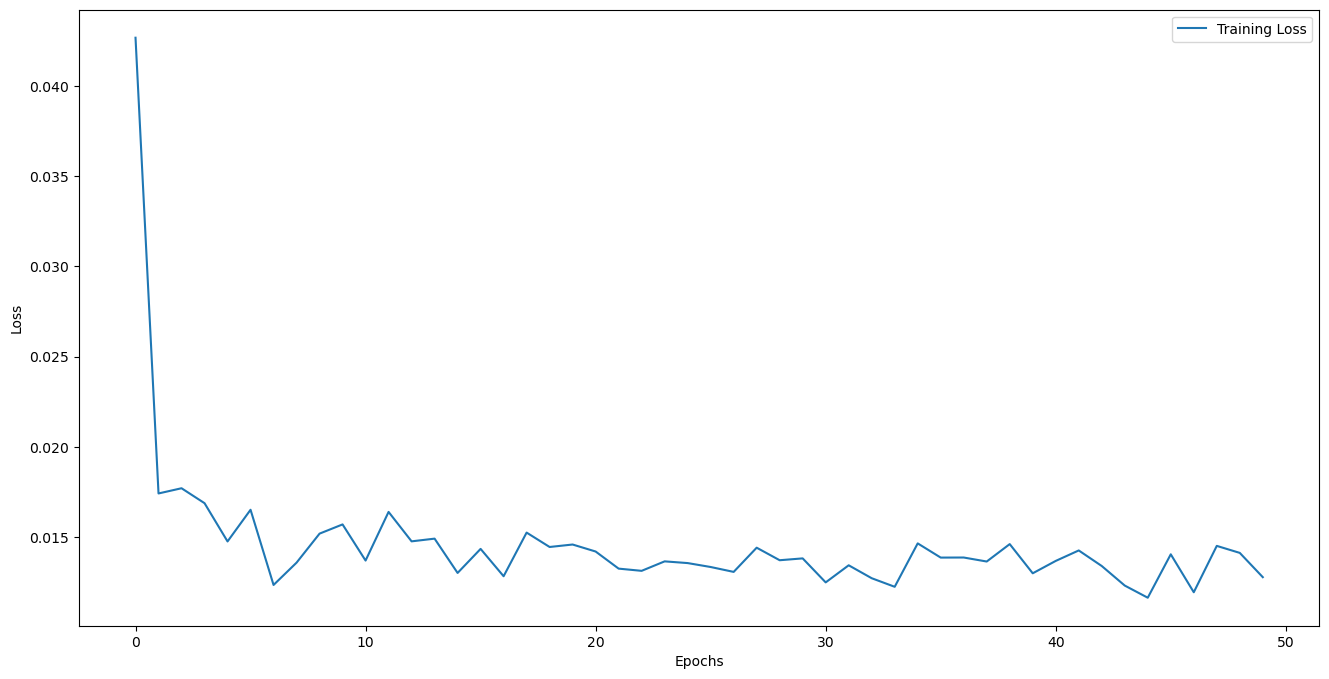

In [160]:
# plot the loss of each epoch
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [161]:
# change train and test to a pandas dataframe
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [162]:
# create a variable for the combined train and test datas
total_dataset = pd.concat((train_data, test_data), axis=0)

In [163]:
# apply scaling to the model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [164]:
# set values for X_test
actual_prices = test_data.values

# create an empty list
X_test = []

for i in range(prediction_days, len(model_inputs)):
    X_test.append(model_inputs[i-prediction_days:i, 0])

# change the values to array
X_test = np.array(X_test)
# reshape to have 3 columns
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

In [134]:
X_test

array([[[3.65057796],
        [3.63647209],
        [3.53814495],
        ...,
        [3.76467053],
        [4.01774853],
        [4.01484439]],

       [[3.63647209],
        [3.53814495],
        [3.52362412],
        ...,
        [4.01774853],
        [4.01484439],
        [4.05176886]],

       [[3.53814495],
        [3.52362412],
        [3.66966249],
        ...,
        [4.01484439],
        [4.05176886],
        [3.9671332 ]],

       ...,

       [[5.77726333],
        [5.79717813],
        [5.92994027],
        ...,
        [6.69124917],
        [6.77215105],
        [6.8318942 ]],

       [[5.79717813],
        [5.92994027],
        [6.07929808],
        ...,
        [6.77215105],
        [6.8318942 ],
        [6.72692845]],

       [[5.92994027],
        [6.07929808],
        [6.04112838],
        ...,
        [6.8318942 ],
        [6.72692845],
        [6.79040599]]])

In [165]:
# get the models predicted price values 
predictions = model.predict(X_test)
predictions = predictions.reshape(-1, 1)
predictions = scaler.inverse_transform(predictions)
#predictions = pd.DataFrame(predictions)

25/25 [==============================] - 1s 5ms/step


In [166]:
type(predictions)

numpy.ndarray

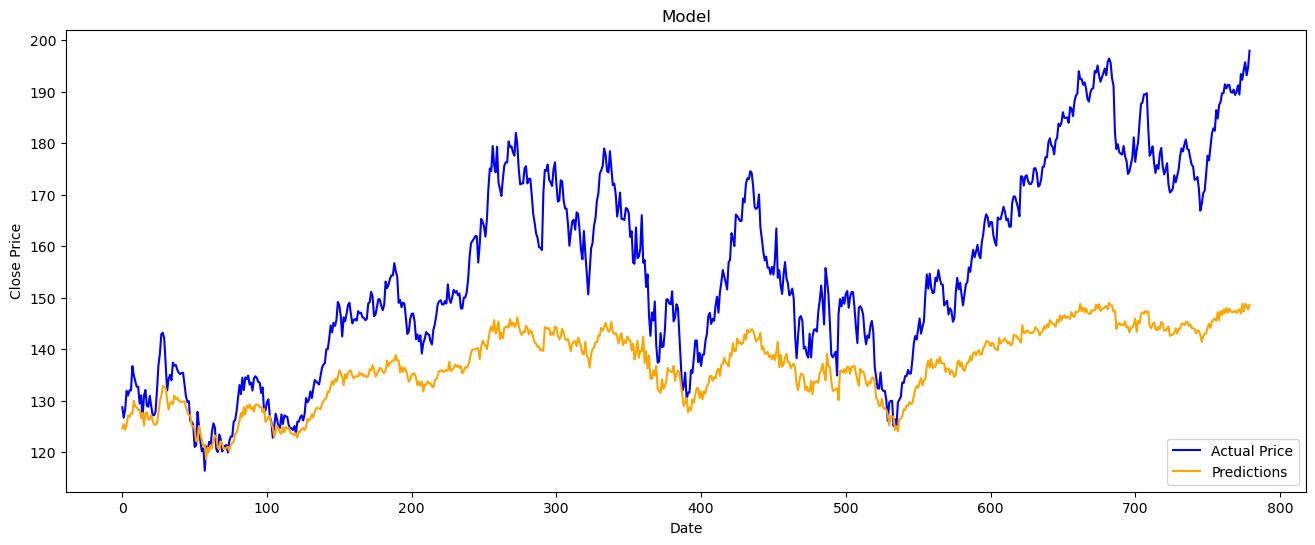

In [167]:
# visualize the LSTM prediction
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(test_data, color='blue', label='Actual Price')
plt.plot(predictions, color='orange', label='Predictions')
plt.legend(loc='lower right')
plt.show()

In [168]:
# get the r2_score metric
from sklearn.metrics import r2_score
r2 = r2_score(test_data, predictions)
print(r2)

-0.29430960689793917


In [169]:
# accuracy metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

l1 = mean_absolute_error(test_data, predictions)
l2 = np.sqrt(mean_squared_error(test_data, predictions))

print(l1, l2)

18.350576071925083 22.27432962360971


In [176]:
# print the MSE and MAPE accuracy metrics
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_data, predictions)
#mape = np.mean(np.abs((test_data, predictions) / test_data)) * 100
print(mse)
#print(mape)

496.145760181217


## Prediction using Prophet

In [32]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [141]:
# import Prophet
from prophet import Prophet
from prophet.plot import plot
from prophet.plot import plot_plotly

Prophet modeling works by looking for the simbols `ds` and `y`, for Date and the value we want to predict, respectively. Therefore, we'll add those values in the desired variables.

In [142]:
# create a Prophet dataframe
aapl_df_pr = pd.DataFrame({'ds': aapl_df_clean.index, 'y': aapl_df_clean['Close']})

In [143]:
# view the new dataframe
aapl_df_pr

ds           y
2009-01-05 2009-01-05    3.377857
2009-01-06 2009-01-06    3.322143
2009-01-07 2009-01-07    3.250357
2009-01-08 2009-01-08    3.310714
2009-01-09 2009-01-09    3.235000
...               ...         ...
2023-12-07 2023-12-07  194.270004
2023-12-08 2023-12-08  195.710007
2023-12-11 2023-12-11  193.179993
2023-12-12 2023-12-12  194.710007
2023-12-13 2023-12-13  197.960007

[3898 rows x 2 columns]

In [144]:
# instantiate the model and fit to the data
model = Prophet(daily_seasonality=True)
model.fit(aapl_df_pr)

20:04:28 - cmdstanpy - INFO - Chain [1] start processing
20:04:29 - cmdstanpy - INFO - Chain [1] done processing


In [145]:
# set the number of prediction days
future_pred = model.make_future_dataframe(periods=365)

In [146]:
# predict the prices
predictions = model.predict(future_pred)

In [147]:
# plot the future prices
plot_plotly(model, predictions)

C:\Users\vitor\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:107: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



At this point we have only predicted the future prices after fitting the entire dataset, however we can not verify how well those predictions would be to forecast future prices.

One way to visualize the performance of Prophet is by plotting the prediction on a test set, like we did with LSTM. So let's proceed to split the data.

In [148]:
# split the data in train and test
train_prophet = aapl_df_pr.iloc[:3000]
test_prophet = aapl_df_pr.iloc[3000 :]

In [149]:
test_prophet.shape

(898, 2)

In [150]:
# fit the model to the train data
model1 = Prophet(daily_seasonality=True)
model1.fit(train_prophet)
future_pred1 = model.make_future_dataframe(periods=898)
predictions1 = model.predict(future_pred1)

20:04:45 - cmdstanpy - INFO - Chain [1] start processing
20:04:45 - cmdstanpy - INFO - Chain [1] done processing


In [151]:
plot_plotly(model, predictions1)

C:\Users\vitor\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:107: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



C:\Users\vitor\AppData\Local\Temp\ipykernel_2572\3667480157.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vitor\AppData\Local\Temp\ipykernel_2572\3667480157.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



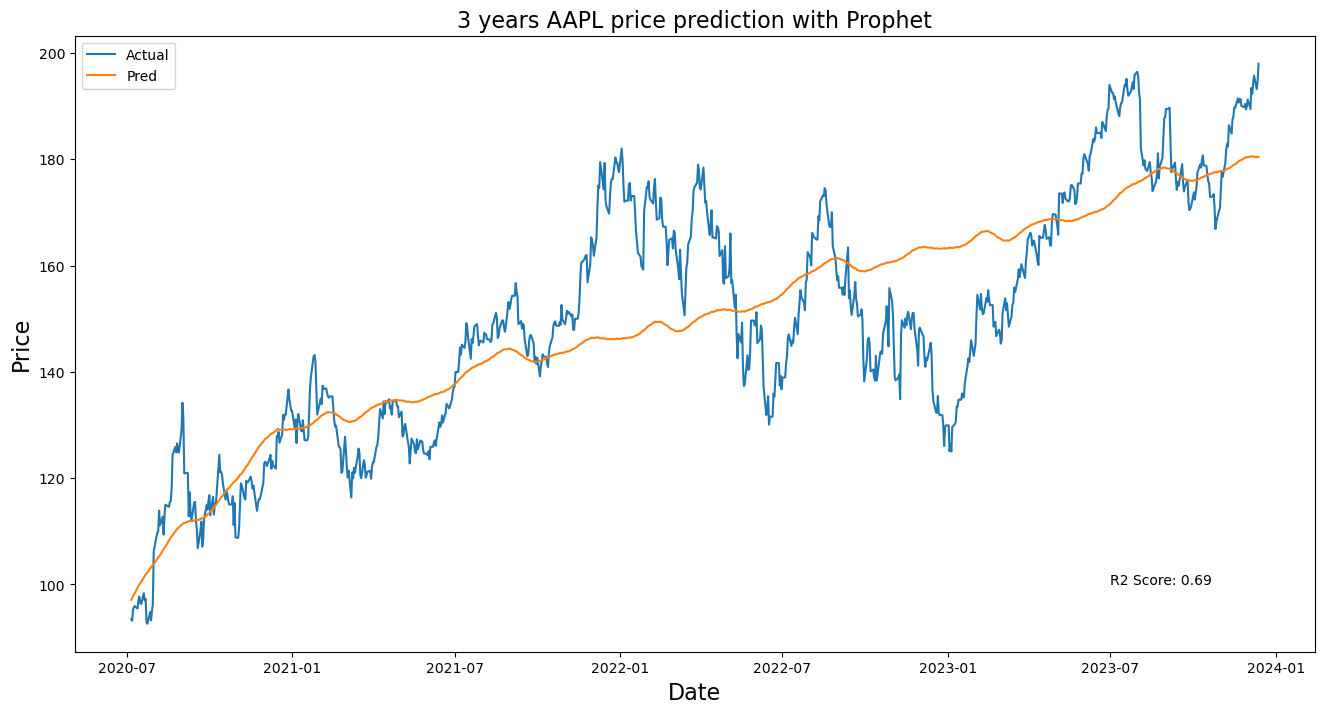

In [156]:
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])
pred['ds'] = pd.to_datetime(pred['ds'])

# plot the predicitons over the original values
plt.figure(figsize=(16, 8))

plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual')
plt.plot(pred['ds'], pred['yhat'], label='Pred')

plt.title('3 years AAPL price prediction with Prophet', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.legend()

# Displaying R2 score
r2 = np.round(r2_score(test_prophet['y'], pred['yhat']), 2)
plt.text(x=pd.Timestamp('2023-07-01'), y=100, s='R2 Score: {}'.format(r2))

plt.show()

In [67]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

# Perform cross-validation
aapl_cv = cross_validation(model, initial='3000', period='1 days', horizon='898 days')

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/4557 [00:00<?, ?it/s]

12:56:10 - cmdstanpy - INFO - Chain [1] start processing
12:56:10 - cmdstanpy - INFO - Chain [1] done processing
12:56:11 - cmdstanpy - INFO - Chain [1] start processing
12:56:11 - cmdstanpy - INFO - Chain [1] done processing
12:56:11 - cmdstanpy - INFO - Chain [1] start processing
12:56:11 - cmdstanpy - INFO - Chain [1] done processing
12:56:12 - cmdstanpy - INFO - Chain [1] start processing
12:56:12 - cmdstanpy - INFO - Chain [1] done processing
12:56:12 - cmdstanpy - INFO - Chain [1] start processing
12:56:12 - cmdstanpy - INFO - Chain [1] done processing
12:56:12 - cmdstanpy - INFO - Chain [1] start processing
12:56:12 - cmdstanpy - INFO - Chain [1] done processing
12:56:13 - cmdstanpy - INFO - Chain [1] start processing
12:56:13 - cmdstanpy - INFO - Chain [1] done processing
12:56:13 - cmdstanpy - INFO - Chain [1] start processing
12:56:13 - cmdstanpy - INFO - Chain [1] done processing
12:56:14 - cmdstanpy - INFO - Chain [1] start processing
12:56:14 - cmdstanpy - INFO - Chain [1]

In [69]:
df_p = performance_metrics(aapl_cv)
print(df_p.head())

  horizon         mse       rmse       mae      mape     mdape     smape  \
0 90 days  162.558552  12.749845  6.124726  0.367205  0.106672  0.176196   
1 91 days  164.246236  12.815859  6.165215  0.370187  0.107669  0.177623   
2 92 days  165.846654  12.878146  6.204516  0.372892  0.108514  0.179020   
3 93 days  167.283341  12.933806  6.242252  0.375268  0.109494  0.180362   
4 94 days  168.617950  12.985297  6.279033  0.377464  0.110382  0.181644   

   coverage  
0  0.215462  
1  0.213655  
2  0.212080  
3  0.210660  
4  0.209338  


### Conclusion

The fitting of the LSTM model wasn't very accurate with a nearly 100% mean absolute percentage error (MAPE), but after plotting we can see it predicted very well the shape of the graphic, despite being below the actual values. But considering we are analyzing prices of a stock, it can be a good thing to play it more conservatively.

On the other hand the Prophet model didn't predicted the shape as well but had a higher accuracy as well as did very well following the trend.

Moving forward we can look at ways of implementing the Prophet model in conjunction with LSTM. With both combined we could see results that not only predict the trend correctly but fits the original data more accuratly. 